In [70]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import datetime
import os
import sys

In [71]:
from discopro.grammar import tensor
from discopro.anaphora import connect_anaphora_on_top
from lambeq import BobcatParser, NumpyModel, AtomicType, Rewriter, Dataset, QuantumTrainer, SPSAOptimizer , AtomicType, IQPAnsatz, RemoveCupsRewriter, UnifyCodomainRewriter, BinaryCrossEntropyLoss
from lambeq.backend.grammar import Spider, Ty
from lambeq.backend.quantum import Box, qubit, SelfConjugate, Ry, Diagram
from contextuality.model import Model, Scenario, CyclicScenario

In [3]:
remove_cups = RemoveCupsRewriter()

parser = BobcatParser()
rewriter = Rewriter(['auxiliary',
                     'connector',
                     'coordination',
                     'determiner',
                     'object_rel_pronoun',
                     'subject_rel_pronoun',
                     'postadverb',
                     'preadverb',
                     'prepositional_phrase'])

N = AtomicType.NOUN
S = AtomicType.SENTENCE
P = AtomicType.PREPOSITIONAL_PHRASE 

ansatz = IQPAnsatz({N: 1, S: 1, P:1}, n_layers=1, n_single_qubit_params=3) 

In [ ]:
def sent2dig(sentence1: str, sentence2: str, pro: str, ref: str, mode='disjoint'):
    diagram1 = parser.sentence2diagram(sentence1)
    diagram2 = parser.sentence2diagram(sentence2)
    diagram = tensor(diagram1,diagram2)
    
    if mode == 'spider':
        diagram = diagram >> Spider(S, 2, 1)
    elif mode == 'box':
        merger = UnifyCodomainRewriter(Ty('s'))
        diagram = merger(diagram)
    elif mode == 'skip':
        diagram = diagram >> Spider(S, 2, 1)
        return rewriter(remove_cups(final_diagram)).normal_form()
        
    pro_box_idx = next(i for i, box in enumerate(diagram.boxes) if box.name.casefold() == pro.casefold())
    ref_box_idx = next(i for i, box in enumerate(diagram.boxes) if box.name.casefold() == ref.casefold())
    final_diagram = connect_anaphora_on_top(diagram, pro_box_idx, ref_box_idx)
    rewritten_diagram = rewriter(remove_cups(final_diagram)).normal_form()
    return rewritten_diagram

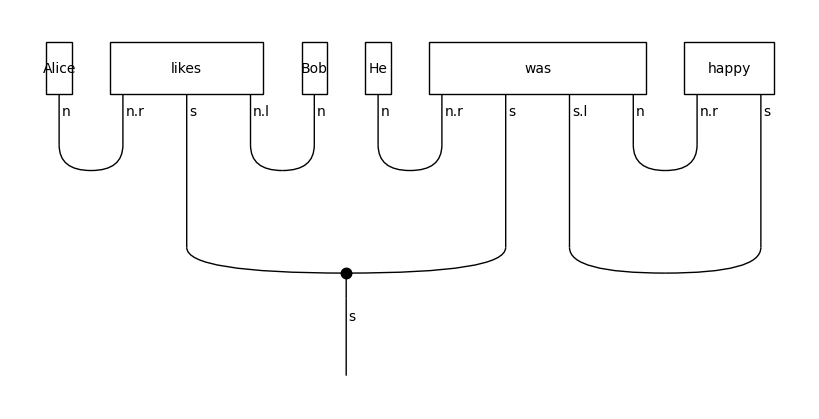

In [88]:
sent2dig('Alice likes Bob', 'He was happy', 'He', 'Bob', mode='skip').draw(figsize=(8,4))

In [5]:
def gen_labels(path: str, verbose=False):
    df = pd.read_csv(path, index_col=0)
    df = df[:100]
    
    if not os.path.exists(os.getcwd()+'/err_logs'):
        os.mkdir(os.getcwd()+'/err_logs')
    timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H_%M_%S")
    f = open("err_logs/log_"+path.split('/')[-1].split('.')[-2]+'_'+timestamp+".txt",'w')
    
    circuits, labels, diagrams = [],[],[]
    #selected_cols = [random.choice(['referent', 'wrong_referent']) for i in range(len(df))]
    for i, row in tqdm(df.iterrows(), total=len(df), position=0, leave=True):
        #ref = row[selected_cols[i]]
        # label = [0,1] if selected_cols[i] == 'referent' else [1,0]
        #label = [[0.25, 0.25],[0.25, 0.25]]
        label = [0,1]
        sent1, sent2, pro, ref = row[['sentence1', 'sentence2', 'pronoun', 'referent']]

        try:
            diagram = sent2dig(sent1.strip(), sent2.strip(), pro.strip(), ref.strip(), mode='spider')
            diagrams.append(diagram)
            circ = ansatz(diagram)
            circuits.append(circ)
            labels.append(label)
        except Exception as err:
            tqdm.write(f"Error: {err}".strip(), file=f)
            if verbose:
                tqdm.write(f"Error: {err}".strip(), file=sys.stderr)
    f.close()
    
    return circuits, labels, diagrams

In [50]:
train_circuits, train_labels, train_diagrams = gen_labels('dataset/original_data/train.csv')
val_circuits, val_labels, val_diagrams = gen_labels('dataset/original_data/val.csv')
test_circuits, test_labels, test_diagrams = gen_labels('dataset/original_data/test.csv')

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:40<00:00,  2.48it/s]


In [67]:
model = NumpyModel.from_diagrams(train_circuits + val_circuits + test_circuits, use_jit=True)
loss = BinaryCrossEntropyLoss(use_jax=True)
acc = lambda y_hat, y: np.sqrt(np.mean((np.array(y_hat)-np.array(y))**2)/2)

In [54]:
SEED = random.randint(0, 1000)
BATCH_SIZE = 20
EPOCHS = 100

In [55]:
train_dataset = Dataset(train_circuits, train_labels, batch_size=BATCH_SIZE)
val_dataset = Dataset(val_circuits, val_labels, shuffle=True)
test_dataset = Dataset(test_circuits, test_labels)

In [70]:
trainer = QuantumTrainer(model,
                         loss_function=loss,
                         optimizer=SPSAOptimizer,
                         epochs=EPOCHS,
                         optim_hyperparams={'a': 0.1, 'c': 0.06, 'A': 0.01 * EPOCHS},
                         evaluate_functions={"err": acc},
                         evaluate_on_train=True,
                         verbose='text', 
                         seed=SEED)

In [71]:
print("Learning parameters: "+datetime.datetime.now().strftime("%Y-%m-%d_%H_%M_%S"))
trainer.fit(train_dataset, val_dataset, eval_interval=1, log_interval=1)
test_acc = acc(model(test_dataset.data[:10]), test_dataset.targets[:10])
print('Test accuracy:', test_acc)

Learning parameters: 2024-07-04_14_33_36


Epoch 1:    train/loss: 1.2972   valid/loss: 1.1715   train/err: 0.4334   valid/err: 0.4290
Epoch 2:    train/loss: 1.0510   valid/loss: 1.3518   train/err: 0.4289   valid/err: 0.4415
Epoch 3:    train/loss: 2.1089   valid/loss: 1.1869   train/err: 0.4295   valid/err: 0.4079
Epoch 4:    train/loss: 0.3932   valid/loss: 0.7364   train/err: 0.3688   valid/err: 0.3379
Epoch 5:    train/loss: 0.7539   valid/loss: 0.8877   train/err: 0.3560   valid/err: 0.3716
Epoch 6:    train/loss: 1.1157   valid/loss: 0.8964   train/err: 0.3336   valid/err: 0.3795
Epoch 7:    train/loss: 1.3176   valid/loss: 0.8889   train/err: 0.3522   valid/err: 0.3750
Epoch 8:    train/loss: 0.8923   valid/loss: 0.9537   train/err: 0.3667   valid/err: 0.3699
Epoch 9:    train/loss: 0.3370   valid/loss: 0.8621   train/err: 0.3302   valid/err: 0.3509
Epoch 10:   train/loss: 0.6955   valid/loss: 0.8894   train/err: 0.3280   valid/err: 0.3540
Epoch 11:   train/loss: 0.8693   valid/loss: 0.9064   train/err: 0.3427   valid/

Test accuracy: 0.45101258572337755


In [6]:
def train(trainer: QuantumTrainer, EPOCH_ARR: [int], BATCH_ARR: [int], SEED_N: int, train_dataset: Dataset, val_dataset: Dataset, test_dataset: Dataset):
    SEEDS = random.sample(range(1000), SEED_N)
    trainer.verbose = 'supress'
    model = trainer.model
    
    print("%0s %23s %7s %7s  %12s" % ("Time","Epochs","Batch","Seed","Accuracy"))
    for EPOCHS in EPOCH_ARR:
        for BATCH_SIZE in BATCH_ARR:
            for SEED in SEEDS:
                trainer.epochs = EPOCHS
                trainer.optim_hyperparams = {'a': 0.1, 'c': 0.06, 'A': 0.01 * EPOCHS}
                train_dataset.batch_size = BATCH_SIZE
                time = datetime.datetime.now().strftime("%Y-%m-%d_%H_%M_%S")
                print("%0s %8s %7s %7s" % (time, EPOCHS, BATCH_SIZE, SEED), end='')
                trainer.fit(train_dataset, val_dataset, eval_interval=1, log_interval=1)
                test_acc = acc(model(test_dataset.data), test_dataset.targets)
                print("%14s" % (round(test_acc, 6)))

In [97]:
class data_scenario:
    def __init__(self, scenario, df_path=None, model_path=None):
        self.data = pd.DataFrame(columns=["Sentence", "CF", "SF", "CbD", "DI", "Violation", "PrDist"])
        self.scenario = scenario # Measurement scenario modelling the schema
        self.diagrams = self.get_diagrams(df_path) # Df is a dataframe with rows of text
        self.model = NumpyModel.from_checkpoint(model_path) # Model is a NumpyModel with learnt parameters for ansatz circuits
        try:
            self.model.initialise_weights()
        except Exception as err:
            print("Model is not valid or none provided: ", err)
        
        self.bases = {'a':Ry(0), 'A':Ry(np.pi/4), 'b':Ry(np.pi/8), 'B':Ry(3*np.pi/8)}
        self.pairs = {'ab': np.kron(Ry(0).array, Ry(np.pi/8).array),
                      'aB': np.kron(Ry(0).array, Ry(np.pi/8).array),
                      'Ab': np.kron(Ry(np.pi/4).array, Ry(3*np.pi/8).array),
                      'AB': np.kron(Ry(np.pi/4).array, Ry(3*np.pi/8).array)}

    def get_diagrams(self, df_path):
        if not df_path:
            return None
        df = pd.read_csv(df_path)
        diagrams = []
        sentences = []
        for _, row in tqdm(df.iterrows(), total=len(df)):
            try:
                s1, s2, pro, ref = row[['sentence1','sentence2','pronoun','referent']]
                diagrams.append(ansatz(sent2dig(s1, s2, pro, ref)))
                sentences.append(s1 + ". " + s2 + ".")
            except Exception as err:
                tqdm.write(f"Error: {err}".strip(), file=sys.stderr)
        self.data['Sentence'] = sentences 
        return diagrams

    def load_data(self, path):
        self.data = pd.read_csv(path)

    def get_emp_model(self, diag):
        diagXX = diag.apply_gate(self.bases['a'],0).apply_gate(self.bases['b'],1)
        diagXZ = diag.apply_gate(self.bases['a'],0).apply_gate(self.bases['B'],1)
        diagZX = diag.apply_gate(self.bases['A'],0).apply_gate(self.bases['b'],1)
        diagZZ = diag.apply_gate(self.bases['A'],0).apply_gate(self.bases['B'],1)
        pr_dist = [self.model.get_diagram_output([diagXX])[0].flatten()]
        pr_dist.append(self.model.get_diagram_output([diagXZ])[0].flatten())
        pr_dist.append(self.model.get_diagram_output([diagZX])[0].flatten())
        pr_dist.append(self.model.get_diagram_output([diagZZ])[0].flatten())
        #dist = self.model.get_diagram_output([diagXX, diagXZ, diagZX, diagZZ])
        return Model(self.scenario, pr_dist)

    def calc_violation(self, state):
        state = np.sqrt(state)
        expectations = [np.matmul(state, np.matmul(self.pairs['ab'], state))]
        expectations.append(np.matmul(state, np.matmul(self.pairs['aB'], state)))
        expectations.append(np.matmul(state, np.matmul(self.pairs['Ab'], state)))
        expectations.append(np.matmul(state, np.matmul(self.pairs['AB'], state)))
        return abs(sum(expectations) - 2*min(expectations))

    def gen_data(self):
        cf_arr, sf_arr, cbd_arr, di_arr, bell_viol_arr, pr_dist_arr = [], [], [], [], [], []
        for diagram in tqdm(self.diagrams, total=len(self.diagrams)):
            cur_emp_model = self.get_emp_model(diagram)
            cf_arr.append(cur_emp_model.contextual_fraction())
            sf_arr.append(cur_emp_model.signalling_fraction())
            cbd_arr.append(cur_emp_model.CbD_measure())
            di_arr.append(cur_emp_model.CbD_direct_influence())
            state = self.model.get_diagram_output([diagram])[0].flatten()
            bell_viol_arr.append(self.calc_violation(state))
            pr_dist_arr.append(cur_emp_model._distributions)
        self.data['CF'] = cf_arr
        self.data['SF'] = sf_arr
        self.data['CbD'] = cbd_arr
        self.data['DI'] = di_arr
        self.data['Violation'] = bell_viol_arr
        self.data['PrDist'] = pr_dist_arr
        self.data.to_csv('dataset/scenario442_' + str(len(self.diagrams)) + '_' + datetime.datetime.now().strftime("%Y-%m-%d_%H_%M_%S") + '.csv')

    def plot_cnxt(self, save=True):
        sf = self.data['SF'].to_numpy()
        di = self.data['DI'].to_numpy()
        plt.scatter(sf, di)
        plt.axhline(y=2, color='g', linestyle='-')
        plt.axvline(x=1/6, color='g', linestyle='-')
        plt.xlabel('Signalling Fraction')
        plt.ylabel('CbD Influence')
        if save:
            plt.savefig('figures/context_' + datetime.datetime.now().strftime("%Y-%m-%d_%H_%M_%S"))
        plt.show()

    def plot_violation(self, save=True):
        sf, di, chsh = self.data[['SF', 'CbD', 'Violation']]
        sf = self.data['SF'].to_numpy()
        di = self.data['DI'].to_numpy()
        chsh = self.data['Violation'].to_numpy()
        x, y = np.meshgrid(sf, di)
        data = pd.DataFrame(data={'x': sf, 'y': di, 'z': chsh})
        data = data.pivot(index='x', columns='y', values='z')
        z = data.to_numpy()
        #z = z[:-1, :-1]
        fig, ax = plt.subplots()
        c = ax.pcolormesh(x, y, z, cmap='RdBu', vmin=0, vmax=2*np.sqrt(2))
        ax.set_title('Title')
        ax.axis([x.min(), x.max(), y.min(), y.max()])
        fig.colorbar(c, ax=ax, label='Violation')
        plt.xlabel('Signalling Fraction')
        plt.ylabel('CbD Influence')
        if save:
            plt.savefig('figures/violation_' + datetime.datetime.now().strftime("%Y-%m-%d_%H_%M_%S"))
        plt.show()

In [ ]:
tmp = data_scenario(scenario=CyclicScenario(['a','b','A','B'],2),
                    df_path='dataset/original_data/test.csv',
                    model_path='runs/spider_200epochs/best_model.lt')
tmp.gen_data();

Error: Diagram 0 (cod=) does not compose with diagram 1 (dom=qubit)              
Error: Diagram 0 (cod=) does not compose with diagram 1 (dom=qubit)              
Error: Diagram 0 (cod=n @ n.r @ n @ n) does not compose with diagram 1 (dom=n @ p.r @ n)
Error: Diagram 0 (cod=) does not compose with diagram 1 (dom=qubit)              
Error: Diagram 0 (cod=) does not compose with diagram 1 (dom=qubit)              
Error: Diagram 0 (cod=) does not compose with diagram 1 (dom=qubit)              
Error: Diagram 0 (cod=) does not compose with diagram 1 (dom=qubit)              
Error: Diagram 0 (cod=) does not compose with diagram 1 (dom=qubit)              
Error: Diagram 0 (cod=) does not compose with diagram 1 (dom=qubit)              
Error: Diagram 0 (cod=n @ n.r @ n @ n) does not compose with diagram 1 (dom=n @ p.r @ n)
Error: Diagram 0 (cod=n @ n.r @ n @ n) does not compose with diagram 1 (dom=n @ p.r @ n)
Error: Diagram 0 (cod=) does not compose with diagram 1 (dom=qubit)          

In [75]:
tmp.load_data('dataset/tmp/scenario442_3057_2024-07-08_10_11_03.csv')

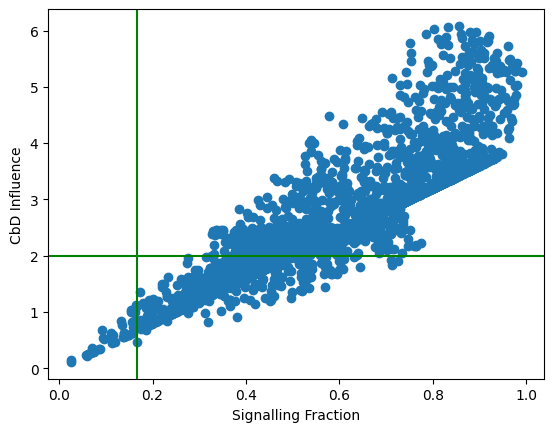

In [76]:
tmp.plot_cnxt()

/var/folders/4l/tt87xtsj7fz7986r0pkv68980000gn/T/ipykernel_2019/1358996416.py:98: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  c = ax.pcolormesh(x, y, z, cmap='RdBu', vmin=0, vmax=2*np.sqrt(2))


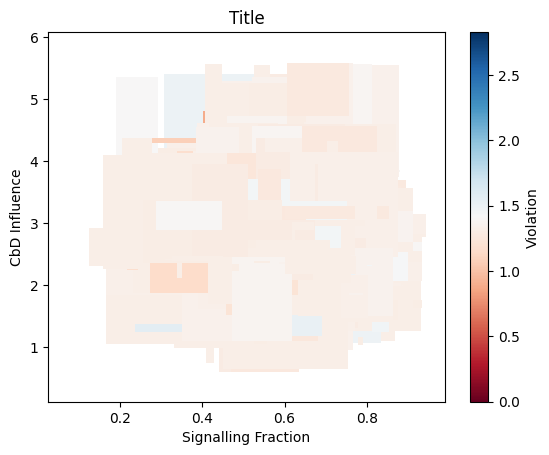

In [77]:
tmp.plot_violation()

In [74]:
model=NumpyModel.from_checkpoint('runs/Jul04_14-33-35_TLS-MBP.local/best_model.lt')
model.initialise_weights()

In [77]:
data = pd.read_csv('dataset/original_data/test.csv')[:100]
s1, s2, pro, ref = data.iloc[random.randint(0,len(data))][['sentence1', 'sentence2', 'pronoun', 'referent']]
diag_og = ansatz(sent2dig(s1, s2, pro, ref, mode='none'))
diag_sp = ansatz(sent2dig(s1, s2, pro, ref, mode='spider'))

In [79]:
model.get_diagram_output([diag_og])[0]

array([[0.45872997, 0.1766415 ],
       [0.18094657, 0.18368195]])

AttributeError: 'NoneType' object has no attribute 'show'

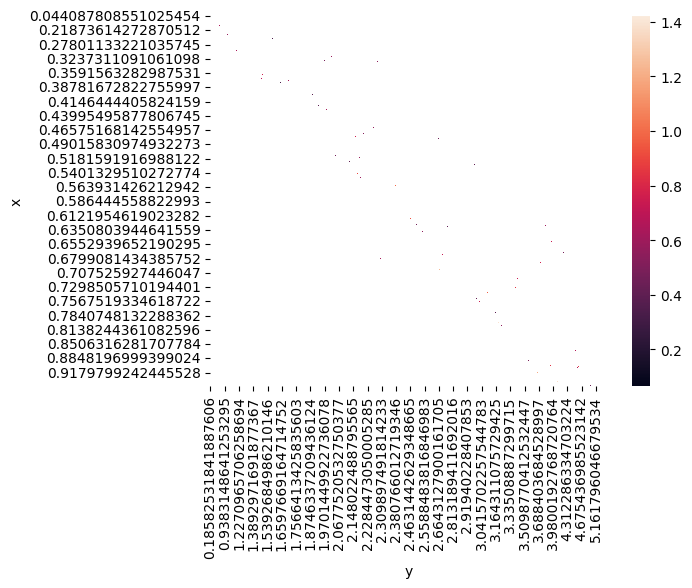

In [229]:
import seaborn as sns
sf, di, chsh = [], [], []
for mod, diag in zip(tmp.emp_models, tmp.diagrams):
    sf.append(mod.signalling_fraction())
    di.append(mod.CbD_direct_influence())
    chsh.append(tmp.calc_chsh(tmp.model.get_diagram_output([diag])[0].flatten()))
data = pd.DataFrame(data={'x':sf, 'y':di, 'z':chsh})
data = data.pivot(index='x', columns='y', values='z')
sns.heatmap(data)
plt.show()